In [20]:
import pandas as pd
data = pd.read_csv(r"C:\Users\supre\Downloads\Problem Statement - Blinkit - data.csv")

In [21]:
data.isnull().sum()

order_id_new                0
order_try_id_new            0
calc_created                0
metered_price              20
upfront_price            1534
distance                    0
duration                    0
gps_confidence              0
entered_by                  0
b_state                     0
dest_change_number          0
prediction_price_type      20
predicted_distance         20
predicted_duration         20
change_reason_pricing    4645
ticket_id_new               0
rider_app_version          16
order_state                 0
order_try_state             0
driver_app_version          0
driver_device_uid_new       0
device_name                 0
us_indicator                0
overpaid_ride_ticket        0
fraud_score              2759
dtype: int64

In [22]:

data = data.dropna(subset=['upfront_price', 'metered_price'], how='all')


In [23]:
data['change_reason_pricing'].fillna('No Destination change', inplace=True)


In [24]:
import pandas as pd
import numpy as np

def impute_upfront_price(data):
    # Calculate median of available upfront_price
    median_upfront_price = data['upfront_price'].median()
    
    # Condition: distance > predicted_distance
    condition_greater = (data['distance'] > data['predicted_distance'])
    data.loc[condition_greater & data['upfront_price'].isna(), 'upfront_price'] = (
        data.loc[condition_greater, 'metered_price'] * 0.9
    ).clip(lower=median_upfront_price)
    
    # Condition: distance < predicted_distance
    condition_less = (data['distance'] < data['predicted_distance'])
    data.loc[condition_less & data['upfront_price'].isna(), 'upfront_price'] = (
        data.loc[condition_less, 'metered_price'] * 0.95
    ).clip(lower=median_upfront_price)
    
    # Condition: distance == predicted_distance
    condition_equal = (data['distance'] == data['predicted_distance'])
    data.loc[condition_equal & data['upfront_price'].isna(), 'upfront_price'] = (
        data.loc[condition_equal, 'metered_price']
    )
    
    # For any remaining NaN values, use the median of available upfront_price
    data['upfront_price'].fillna(median_upfront_price, inplace=True)

    return data

# Apply the imputation function
data = impute_upfront_price(data)

# Verify the imputation
print(data['upfront_price'].isna().sum())


0


In [25]:
data['price_deviation'] = data.apply(
    lambda row: abs((row['metered_price'] - row['upfront_price']) / row['upfront_price']) * 100 
    if row['metered_price'] > row['upfront_price'] 
    else 0, 
    axis=1)

In [26]:
from sklearn.preprocessing import LabelEncoder

# Sample data creation (use your actual DataFrame here)
# data = pd.read_csv('your_data.csv') # Uncomment this if you're reading from a file

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the column, replacing the original column with encoded values
data['order_state'] = label_encoder.fit_transform(data['order_state'])

In [27]:
data = pd.get_dummies(data, columns=['entered_by'], prefix='entered_by')

In [28]:
data = pd.get_dummies(data, columns=['change_reason_pricing'], prefix='change_reason_pricing')

In [29]:
data_encoded = pd.get_dummies(data, columns=['prediction_price_type'], prefix='price_type')

# Update the original DataFrame with the new one-hot encoded columns
data = data_encoded

In [30]:
def frequency_encoding(df, column):
    freq = df[column].value_counts()
    df[column + '_freq'] = df[column].map(freq).astype(int)
    return df

# Apply frequency encoding to the columns
data = frequency_encoding(data, 'rider_app_version')
data = frequency_encoding(data, 'driver_app_version')



In [36]:
data.drop(columns=['b_state'], inplace=True)
data.drop(columns=['order_try_state'], inplace = True)


In [37]:

data.drop(columns=['device_name'], inplace = True)


In [38]:

data.drop(columns=['driver_device_uid_new'], inplace = True) 

In [35]:
data['fraud_score'].fillna(0, inplace=True)

In [31]:
rider_frequencies = data['rider_app_version'].value_counts()
print(rider_frequencies)

CI.4.17    721
CI.4.19    624
CA.5.44    560
CA.5.43    406
CA.5.42    365
          ... 
CI.3.82      1
CA.5.16      1
CI.3.85      1
CA.4.27      1
CI.3.93      1
Name: rider_app_version, Length: 113, dtype: int64


In [32]:
data.drop(columns=['rider_app_version', 'driver_app_version'], inplace=True)

In [39]:
data.dtypes

order_id_new                                          int64
order_try_id_new                                      int64
calc_created                                         object
metered_price                                       float64
upfront_price                                       float64
distance                                              int64
duration                                              int64
gps_confidence                                        int64
dest_change_number                                    int64
predicted_distance                                  float64
predicted_duration                                  float64
ticket_id_new                                         int64
order_state                                           int32
us_indicator                                          int64
overpaid_ride_ticket                                  int64
fraud_score                                         float64
price_deviation                         

In [40]:
count = (data['price_deviation'] >= 20).sum()

print(f"Number of rows where price_deviation > 20%: {count}")

Number of rows where price_deviation > 20%: 1202


In [43]:
# Filtering the rides with price deviations greater than 20%
large_deviation_rides = data[(data['price_deviation'] >= 20) ]


In [41]:
data['calc_created'] = pd.to_datetime(data['calc_created'], errors='coerce')

In [42]:
#train['datetime'] = pd.to_datetime(train['date'] + ' ' + train['time'])

# Extract meaningful features
data['hour'] = data['calc_created'].dt.hour
data['day'] = data['calc_created'].dt.day
data['month'] = data['calc_created'].dt.month
data['day_of_week'] = data['calc_created'].dt.dayofweek  # Monday=0, Sunday=6

# Optionally drop 'date' and 'time' columns if you don't need them anymore
data.drop(columns=['calc_created'], inplace=True)

In [44]:
large_deviation_rides.shape

(1202, 32)

In [45]:
large_deviation_rides.describe

<bound method NDFrame.describe of       order_id_new  order_try_id_new  metered_price  upfront_price  distance  \
1              618               618           6.09            3.6      5698   
2              657               657           4.32            3.5      4426   
6              761               761       20753.20        10500.0     10459   
9             1999              1999           4.14            2.5      3845   
13            3299              3299           7.65            6.3     13355   
...            ...               ...            ...            ...       ...   
4925          3302              3302           5.49            4.2      8460   
4927          3831              3831           9.61            6.9     15342   
4933          2038              2038           6.94            5.0      4705   
4937          3236              3236           7.01            5.6     10919   
4942           759               759       29244.10        16000.0     17825   

     

In [52]:
large_deviation_rides.dtypes

metered_price                                       float64
upfront_price                                       float64
distance                                              int64
duration                                              int64
gps_confidence                                        int64
dest_change_number                                    int64
predicted_distance                                  float64
predicted_duration                                  float64
ticket_id_new                                         int64
order_state                                           int32
us_indicator                                          int64
overpaid_ride_ticket                                  int64
fraud_score                                         float64
price_deviation                                     float64
entered_by_client                                     uint8
entered_by_driver                                     uint8
change_reason_pricing_No Destination cha

In [53]:
def split_data_X_y(df, target_feature):
    y = df[target_feature]
    X = df.drop(columns=target_feature)
    return X, y

In [54]:
target_feature = ['price_deviation']
X, y = split_data_X_y(large_deviation_rides, target_feature)

In [55]:
from sklearn.feature_selection import mutual_info_regression

def feature_selection(X, y, mutual_info_method, top_n=10):
    mutual_info = mutual_info_method(X, y)
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'ImportanceFactor': mutual_info
    })
    importance_df = pd.DataFrame(importance_df, columns=['Feature', 'ImportanceFactor'])
    importance_df = importance_df.sort_values(by='ImportanceFactor', ascending=False)
    importance_df = importance_df.head(top_n)
    return importance_df

In [56]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

def split_data_X_y(df, target_feature):
    y = df[target_feature]
    X = df.drop(columns=target_feature)
    return X, y

def feature_selection(X, y, mutual_info_method, top_n=10, exclude_features=None):
    if exclude_features is None:
        exclude_features = []

    # Check if y is a DataFrame or Series
    if isinstance(y, pd.DataFrame):
        importance_dfs = []
        
        # Loop over each target column separately
        for target_col in y.columns:
            # Calculate mutual information for the specific target column
            mutual_info = mutual_info_method(X, y[target_col])
            
            # Create a DataFrame to store feature importance for the target
            importance_df = pd.DataFrame({
                'Feature': X.columns,
                'ImportanceFactor': mutual_info,
                'Target': target_col
            })
            
            # Filter out the excluded features
            importance_df = importance_df[~importance_df['Feature'].isin(exclude_features)]
            
            # Sort by importance factor and select top_n
            importance_df = importance_df.sort_values(by='ImportanceFactor', ascending=False)
            importance_df = importance_df
            
            # Append to the list of importance DataFrames
            importance_dfs.append(importance_df)
        
        # Combine the results for all target columns into one DataFrame
        return pd.concat(importance_dfs)
    
    elif isinstance(y, pd.Series):
        # Calculate mutual information for the single target column
        mutual_info = mutual_info_method(X, y)
        
        # Create a DataFrame to store feature importance
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'ImportanceFactor': mutual_info
        })
        
        # Filter out the excluded features
        importance_df = importance_df[~importance_df['Feature'].isin(exclude_features)]
        
        # Sort by importance factor and select top_n
        importance_df = importance_df.sort_values(by='ImportanceFactor', ascending=False)
        #importance_df = importance_df.head(top_n)
        
        return importance_df

# Sample DataFrame (use your actual DataFrame here)
# data = pd.read_csv('your_data.csv') # Uncomment this if you're reading from a file

target_feature = 'price_deviation'
X, y = split_data_X_y(large_deviation_rides, target_feature)

# Define features to exclude
exclude_features = ['upfront_price', 'metered_price']

# Call the feature selection function with the exclusion list
importance_df = feature_selection(X, y, mutual_info_regression, exclude_features=exclude_features)

# Display the results
print(importance_df)


                                             Feature  ImportanceFactor
2                                           distance          0.368378
3                                           duration          0.365144
7                                 predicted_duration          0.263048
25                                              hour          0.220516
24                           driver_app_version_freq          0.212220
6                                 predicted_distance          0.201228
26                                               day          0.179955
12                                       fraud_score          0.175004
23                            rider_app_version_freq          0.163585
10                                      us_indicator          0.160861
4                                     gps_confidence          0.160440
28                                       day_of_week          0.140915
8                                      ticket_id_new          0.125910
27    

In [57]:
def get_categorical_features(df, nunique_threshold=35):
    all_df_columns = df.columns
    categorical_features = [col for col in all_df_columns if df[col].nunique() < nunique_threshold]
    return categorical_features

def get_numerical_features(df, nunique_threshold=35):
    numerical_df_columns = df.select_dtypes(include=[np.number]).columns
    numerical_features   = [col for col in numerical_df_columns if df[col].nunique() >= nunique_threshold]
    return numerical_features

In [59]:
categorical_features = get_categorical_features(large_deviation_rides)
numerical_features   = get_numerical_features(large_deviation_rides)
print(f'categorical_features: {len(categorical_features)}\n{categorical_features}\n')
print(f'numerical_features:   {len(numerical_features)}\n{numerical_features}\n')

categorical_features: 20
['gps_confidence', 'dest_change_number', 'order_state', 'us_indicator', 'overpaid_ride_ticket', 'entered_by_client', 'entered_by_driver', 'change_reason_pricing_No Destination change', 'change_reason_pricing_client_destination_changed', 'change_reason_pricing_driver_destination_changed', 'change_reason_pricing_driver_waypoint_changed', 'price_type_prediction', 'price_type_upfront', 'price_type_upfront_destination_changed', 'price_type_upfront_waypoint_changed', 'driver_app_version_freq', 'hour', 'day', 'month', 'day_of_week']

numerical_features:   10
['metered_price', 'upfront_price', 'distance', 'duration', 'predicted_distance', 'predicted_duration', 'ticket_id_new', 'fraud_score', 'price_deviation', 'rider_app_version_freq']



In [60]:
from sklearn.metrics         import mean_absolute_error, \
                                    mean_squared_error, \
                                    mean_absolute_percentage_error, \
                                    median_absolute_error, \
                                    max_error, \
                                    r2_score, \
                                    explained_variance_score

def evaluate_model(y_test, y_pred):
    mae   = mean_absolute_error(y_test, y_pred)
    mse   = mean_squared_error(y_test, y_pred)
    mape  = mean_absolute_percentage_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    me    = max_error(y_test, y_pred)
    r2    = r2_score(y_test, y_pred)
    ev    = explained_variance_score(y_test, y_pred)

    result = {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Mean Absolute Percentage Error': mape,
        'Median Absolute Error': medae,
        'Max Error': me,
        'R^2': r2,
        'Explained Variance': ev,
    }
    return result

In [61]:
from sklearn.linear_model    import LinearRegression, \
                                    Ridge

from sklearn.tree            import DecisionTreeRegressor
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.ensemble        import RandomForestRegressor

baseline_models = {
    'LinearRegression':          LinearRegression(),
    'Ridge':                     Ridge(),
    'DecisionTreeRegressor':     DecisionTreeRegressor(),

    'RandomForestRegressor':     RandomForestRegressor(),
    'KNeighborsRegressor':       KNeighborsRegressor()
}

In [62]:
import time

def run_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        print(f'Model {name} begining now ...')
        begin_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = evaluate_model(y_test, y_pred)
        end_time = time.time()
        duration = round((end_time - begin_time) / 60, 2)
        print(f'Model {name} run in'.ljust(50), f'{duration} minutes')
    results = pd.DataFrame(results).T
    results = results.reset_index()
    results = results.rename(columns={'index': 'Model'})
    return results

In [63]:
from sklearn.model_selection import train_test_split

def split_data_train_test(df, target_feature, test_size=0.2):
    y = df[target_feature]
    X = df.drop(columns=[target_feature])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [64]:
X_train, X_test, y_train, y_test = split_data_train_test(large_deviation_rides, target_feature)

In [65]:
models_result1 = run_models(baseline_models, X_train, X_test, y_train, y_test)

Model LinearRegression begining now ...
Model LinearRegression run in                      0.01 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.0 minutes
Model DecisionTreeRegressor begining now ...
Model DecisionTreeRegressor run in                 0.0 minutes
Model RandomForestRegressor begining now ...
Model RandomForestRegressor run in                 0.01 minutes
Model KNeighborsRegressor begining now ...
Model KNeighborsRegressor run in                   0.01 minutes


In [66]:
models_result1

,Model,Mean Absolute Error,Mean Squared Error,Mean Absolute Percentage Error,Median Absolute Error,Max Error,R^2,Explained Variance
0,LinearRegression,22.044724,1946.896032,0.387511,13.149161,402.959605,0.828843,0.828866
1,Ridge,22.019849,1946.878756,0.386910,13.055713,403.075150,0.828845,0.828866
2,DecisionTreeRegressor,19.588367,2956.602603,0.290225,6.022827,493.974868,0.740077,0.740077
3,RandomForestRegressor,15.223716,1420.192113,0.226691,5.914137,318.685665,0.875147,0.876133
4,KNeighborsRegressor,22.166531,3473.350125,0.282601,7.969263,485.902005,0.694648,0.705938


In [67]:
from sklearn.linear_model    import LinearRegression, \
                                    Ridge
from sklearn.ensemble        import RandomForestRegressor, \
                                    GradientBoostingRegressor, \
                                    AdaBoostRegressor, \
                                    ExtraTreesRegressor
from sklearn.svm             import SVR
from sklearn.tree            import DecisionTreeRegressor
from sklearn.neighbors       import KNeighborsRegressor
from xgboost                 import XGBRegressor
from lightgbm                import LGBMRegressor

models = {
    'XGBRegressor':              XGBRegressor(),
    'LGBMRegressor':             LGBMRegressor(verbose=-1),
    'LinearRegression':          LinearRegression(),
    'Ridge':                     Ridge(alpha=10),
    'DecisionTreeRegressor':     DecisionTreeRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor':         AdaBoostRegressor(),
    'ExtraTreesRegressor':       ExtraTreesRegressor(),
    'KNeighborsRegressor':       KNeighborsRegressor(),
}
#    'RandomForestRegressor':     RandomForestRegressor(),
#    'SupportVectorRegressor':    SVR(),

In [68]:
from sklearn.metrics         import mean_absolute_error, \
                                    mean_squared_error, \
                                    mean_absolute_percentage_error, \
                                    median_absolute_error, \
                                    max_error, \
                                    r2_score, \
                                    explained_variance_score

def evaluate_model(y_tests, y_preds, kf):
    mae, mse, mape, medae, me, r2, ev = 0, 0, 0, 0, 0, 0, 0
    for y_test, y_pred in zip(y_tests, y_preds):
        mae   += mean_absolute_error(y_test, y_pred)
        mse   += mean_squared_error(y_test, y_pred)
        mape  += mean_absolute_percentage_error(y_test, y_pred)
        medae += median_absolute_error(y_test, y_pred)
        me    += max_error(y_test, y_pred)
        r2    += r2_score(y_test, y_pred)
        ev    += explained_variance_score(y_test, y_pred)

    result = {
        'Mean Absolute Error': mae / kf,
        'Mean Squared Error': mse / kf,
        'Mean Absolute Percentage Error': mape / kf,
        'Median Absolute Error': medae / kf,
        'Max Error': me / kf,
        'R^2': r2 / kf,
        'Explained Variance': ev / kf,
    }
    return result

In [69]:
from sklearn.model_selection import train_test_split, KFold

In [70]:
def run_model(model, X, y, kf):
    kfold = KFold(n_splits=kf, shuffle=True, random_state=42)
    y_tests, y_preds = [], []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        y_tests.append(y_test)
        y_preds.append(y_pred)

    return y_tests, y_preds

In [71]:
import time

def run_models(models, X, y, kf=5):
    results = {}
    for name, model in models.items():
        print(f'Model {name} begining now ...')
        begin_time = time.time()
        y_tests, y_preds = run_model(model, X, y, kf)
        results[name] = evaluate_model(y_tests, y_preds, kf)
        end_time = time.time()
        duration = round((end_time - begin_time) / 60, 2)
        print(f'Model {name} run in'.ljust(50), f'{duration} minutes')
    results = pd.DataFrame(results).T
    results = results.reset_index()
    results = results.rename(columns={'index': 'Model'})
    return results

In [72]:
models_result5 = run_models(models, large_deviation_rides, y)

Model XGBRegressor begining now ...
Model XGBRegressor run in                          0.02 minutes
Model LGBMRegressor begining now ...
Model LGBMRegressor run in                         0.02 minutes
Model LinearRegression begining now ...
Model LinearRegression run in                      0.0 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.0 minutes
Model DecisionTreeRegressor begining now ...
Model DecisionTreeRegressor run in                 0.0 minutes
Model GradientBoostingRegressor begining now ...
Model GradientBoostingRegressor run in             0.02 minutes
Model AdaBoostRegressor begining now ...
Model AdaBoostRegressor run in                     0.01 minutes
Model ExtraTreesRegressor begining now ...
Model ExtraTreesRegressor run in                   0.03 minutes
Model KNeighborsRegressor begining now ...
Model KNeighborsRegressor run in                   0.0 minutes


In [73]:
models_result5

,Model,Mean Absolute Error,Mean Squared Error,Mean Absolute Percentage Error,Median Absolute Error,Max Error,R^2,Explained Variance
0,XGBRegressor,1.507540e+00,2.667814e+02,8.134197e-03,1.532922e-01,1.613140e+02,0.973943,0.974103
1,LGBMRegressor,4.213636e+00,5.869095e+02,2.644654e-02,1.657073e-01,2.625754e+02,0.936755,0.936991
2,LinearRegression,2.864009e-13,2.086697e-25,6.999050e-15,2.138734e-13,2.088996e-12,1.000000,1.000000
3,Ridge,1.464122e-04,8.553504e-08,2.818751e-06,8.806676e-05,2.600286e-03,1.000000,1.000000
4,DecisionTreeRegressor,1.116424e+00,2.847945e+02,4.268281e-03,4.539735e-02,1.756110e+02,0.973570,0.973676
5,GradientBoostingRegressor,1.183336e+00,2.201622e+02,8.217354e-03,2.043012e-01,1.455440e+02,0.979207,0.979264
6,AdaBoostRegressor,8.622446e+00,2.782168e+02,2.524463e-01,7.778762e+00,1.496052e+02,0.971760,0.972907
7,ExtraTreesRegressor,7.230136e-01,1.216004e+02,2.858954e-03,1.477337e-02,1.062948e+02,0.988223,0.988260
8,KNeighborsRegressor,1.800346e+01,2.046681e+03,2.660501e-01,7.842688e+00,4.300853e+02,0.774509,0.781523


In [74]:
import pandas as pd

# Sample DataFrame with feature importances
features_df = pd.DataFrame({
    'Feature': ['distance', 'duration', 'predicted_duration', 'hour', 'driver_app_version_freq', 
                'predicted_distance', 'day', 'fraud_score', 'rider_app_version_freq', 
                'us_indicator', 'gps_confidence', 'day_of_week', 'ticket_id_new', 
                'month', 'overpaid_ride_ticket', 'dest_change_number', 
                'change_reason_pricing_client_destination_changed', 
                'change_reason_pricing_No Destination change', 
                'change_reason_pricing_driver_destination_changed', 
                'entered_by_driver', 'price_type_prediction', 'order_state', 
                'price_type_upfront_destination_changed', 
                'price_type_upfront_waypoint_changed', 
                'entered_by_client', 
                'change_reason_pricing_driver_waypoint_changed', 
                'price_type_upfront'],
    'ImportanceFactor': [0.368378, 0.365144, 0.263048, 0.220516, 0.212220, 0.201228, 
                         0.179955, 0.175004, 0.163585, 0.160861, 0.160440, 0.140915, 
                         0.125910, 0.067688, 0.026988, 0.022146, 0.009170, 0.005348, 
                         0.004418, 0.002649, 0.002385, 0.001436, 0.000958, 0.000938, 
                         0.000000, 0.000000, 0.000000]
})

# Get top 5 important features
top_5_features = features_df.nlargest(5, 'ImportanceFactor')['Feature'].tolist()
print("Top 5 important features to drop:", top_5_features)


Top 5 important features to drop: ['distance', 'duration', 'predicted_duration', 'hour', 'driver_app_version_freq']


In [75]:
# Assuming `large_deviation_rides` is your dataset
features_to_drop = top_5_features

# Drop these features from the dataset
X_modified = large_deviation_rides.drop(columns=features_to_drop)

# Assuming `y` is your target variable and is not affected by feature removal


In [77]:
# Run models with the modified dataset
models_result_modified = run_models(models, X_modified, y)
#print(models_result_modified)


Model XGBRegressor begining now ...
Model XGBRegressor run in                          0.02 minutes
Model LGBMRegressor begining now ...
Model LGBMRegressor run in                         0.01 minutes
Model LinearRegression begining now ...
Model LinearRegression run in                      0.0 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.0 minutes
Model DecisionTreeRegressor begining now ...
Model DecisionTreeRegressor run in                 0.0 minutes
Model GradientBoostingRegressor begining now ...
Model GradientBoostingRegressor run in             0.01 minutes
Model AdaBoostRegressor begining now ...
Model AdaBoostRegressor run in                     0.01 minutes
Model ExtraTreesRegressor begining now ...
Model ExtraTreesRegressor run in                   0.02 minutes
Model KNeighborsRegressor begining now ...
Model KNeighborsRegressor run in                   0.0 minutes


In [78]:
models_result_modified

,Model,Mean Absolute Error,Mean Squared Error,Mean Absolute Percentage Error,Median Absolute Error,Max Error,R^2,Explained Variance
0,XGBRegressor,1.570691e+00,3.029607e+02,7.764055e-03,1.488893e-01,1.947986e+02,0.969880,0.970043
1,LGBMRegressor,4.483225e+00,7.107696e+02,3.132322e-02,2.145094e-01,3.061158e+02,0.923094,0.923316
2,LinearRegression,1.448348e-13,4.386188e-26,3.839666e-15,1.211475e-13,9.990231e-13,1.000000,1.000000
3,Ridge,8.246124e-05,3.363030e-08,1.642593e-06,5.297149e-05,1.907252e-03,1.000000,1.000000
4,DecisionTreeRegressor,1.480253e+00,5.283735e+02,4.506794e-03,4.063174e-02,2.080707e+02,0.949943,0.950019
5,GradientBoostingRegressor,1.322101e+00,3.255540e+02,8.269782e-03,1.987716e-01,1.738343e+02,0.969179,0.969258
6,AdaBoostRegressor,8.354804e+00,2.824573e+02,2.332421e-01,7.817690e+00,1.534143e+02,0.970970,0.971711
7,ExtraTreesRegressor,6.129291e-01,1.187936e+02,2.086534e-03,1.360138e-02,8.813321e+01,0.988442,0.988481
8,KNeighborsRegressor,2.379068e+01,3.568398e+03,4.254808e-01,1.122426e+01,6.019287e+02,0.593294,0.596346


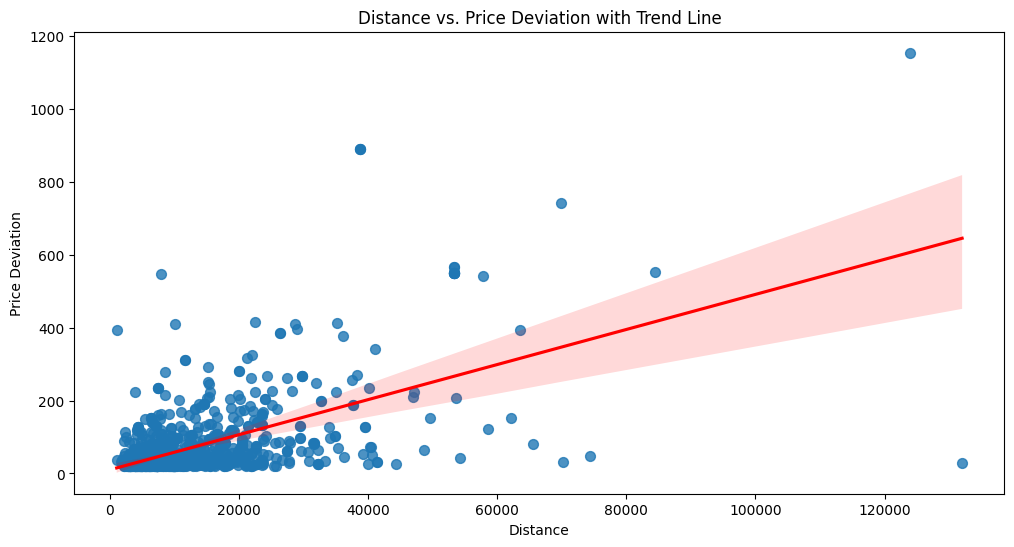

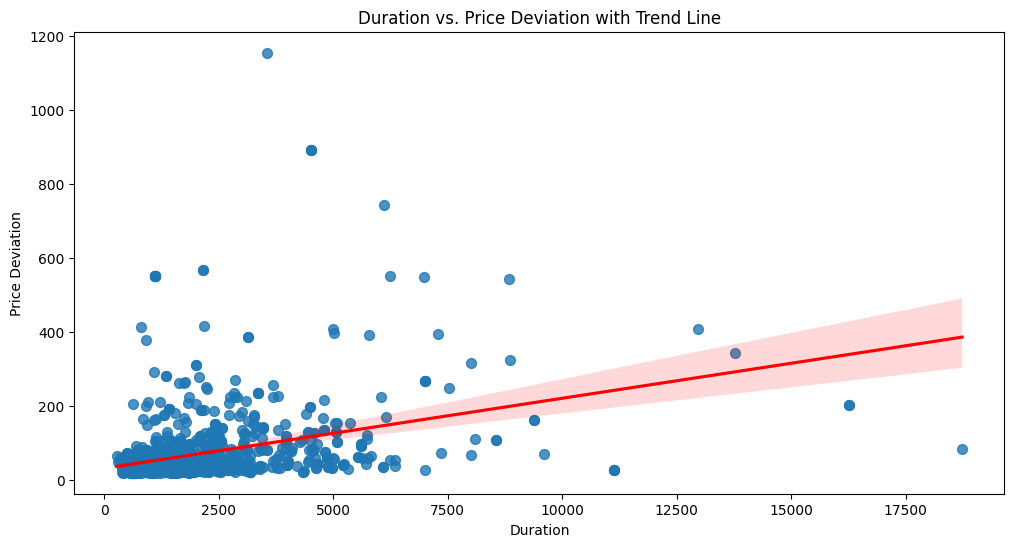

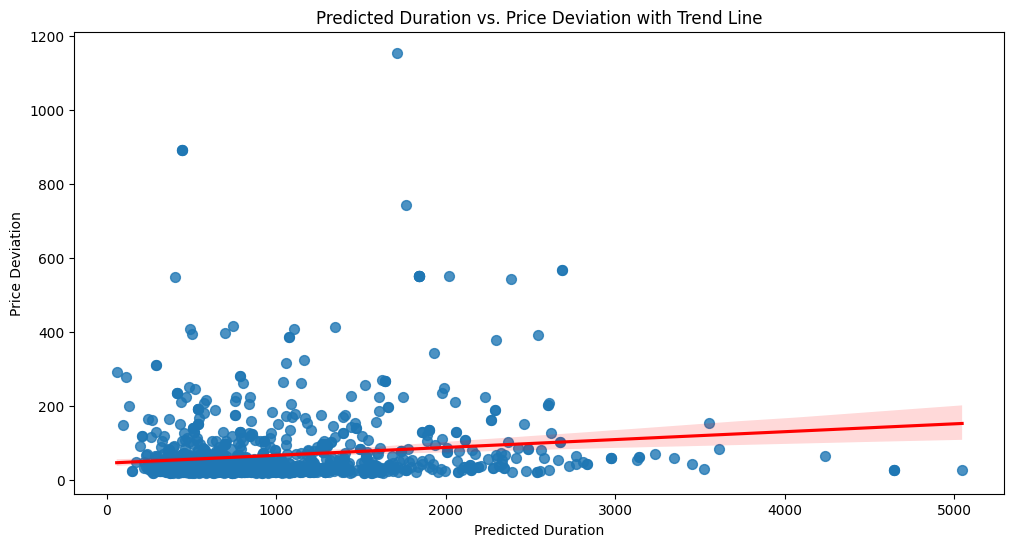

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for distance vs. price_deviation with trend line
plt.figure(figsize=(12, 6))
sns.regplot(x='distance', y='price_deviation', data=large_deviation_rides, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Distance vs. Price Deviation with Trend Line')
plt.xlabel('Distance')
plt.ylabel('Price Deviation')
plt.show()

# Scatter plot for duration vs. price_deviation with trend line
plt.figure(figsize=(12, 6))
sns.regplot(x='duration', y='price_deviation', data=large_deviation_rides, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Duration vs. Price Deviation with Trend Line')
plt.xlabel('Duration')
plt.ylabel('Price Deviation')
plt.show()

# Scatter plot for predicted_duration vs. price_deviation with trend line
plt.figure(figsize=(12, 6))
sns.regplot(x='predicted_duration', y='price_deviation', data=large_deviation_rides, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Predicted Duration vs. Price Deviation with Trend Line')
plt.xlabel('Predicted Duration')
plt.ylabel('Price Deviation')
plt.show()


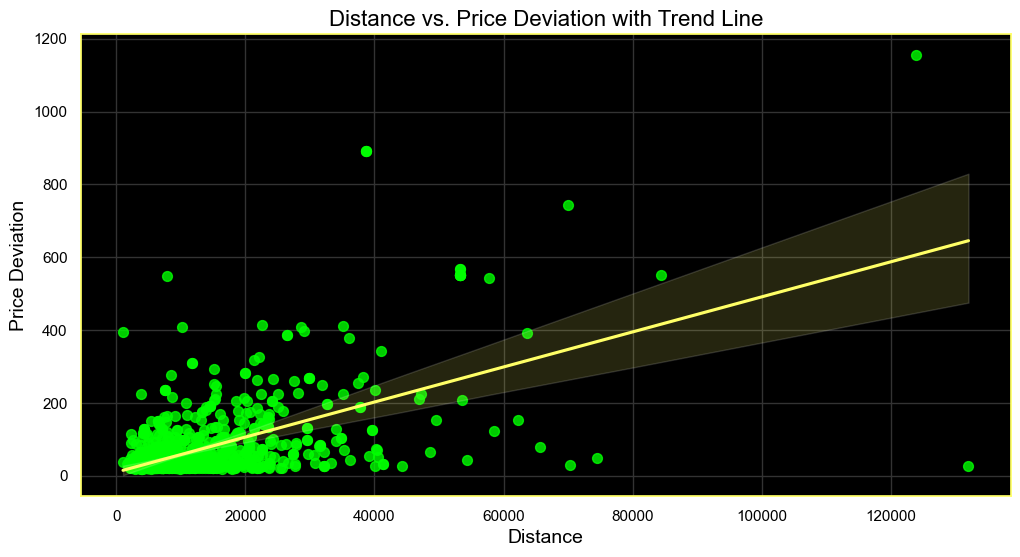

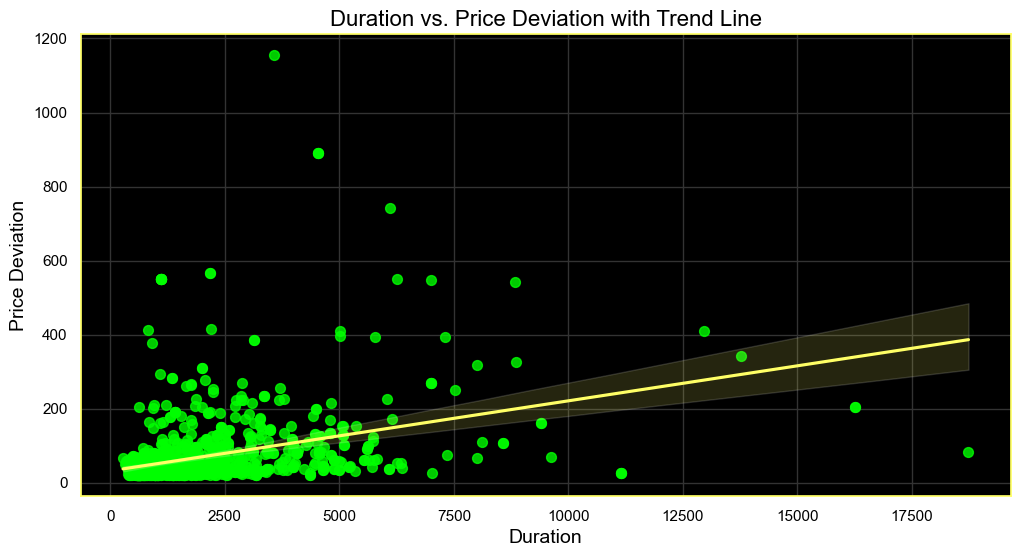

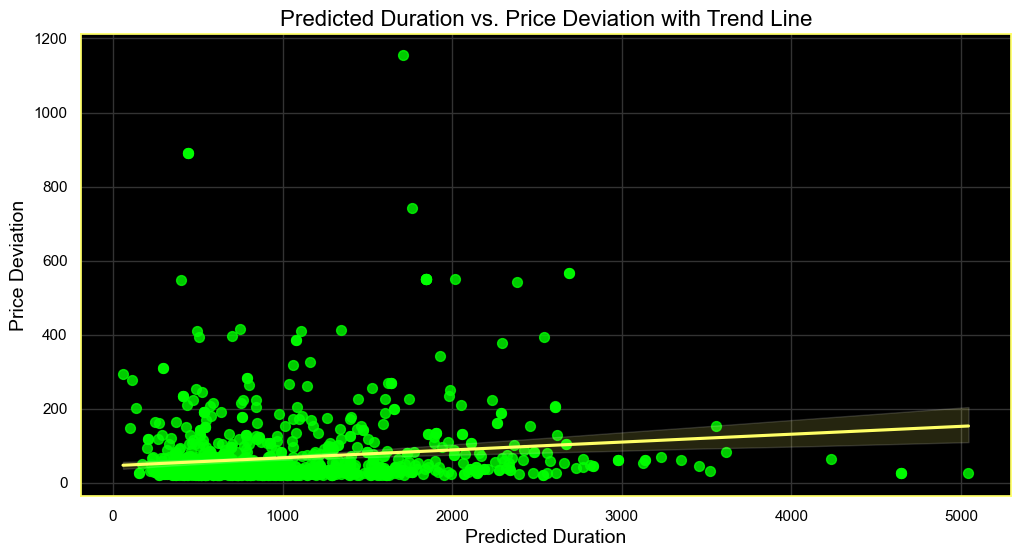

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Blinkit-themed colors with black background and yellow/green accents
sns.set(style='whitegrid')
plt.rcParams['axes.facecolor'] = '#000000'  # black background
plt.rcParams['axes.edgecolor'] = '#FFFF66'  # yellow edge
plt.rcParams['grid.color'] = '#333333'  # subtle dark gridlines (almost black)
plt.rcParams['axes.labelcolor'] = '#000000'  # black labels
plt.rcParams['xtick.color'] = '#000000'  # black x-tick labels
plt.rcParams['ytick.color'] = '#000000'  # black y-tick labels
plt.rcParams['text.color'] = '#000000'  # yellow title

# Scatter plot for distance vs. price_deviation with trend line
plt.figure(figsize=(12, 6))
sns.regplot(x='distance', y='price_deviation', data=large_deviation_rides, scatter_kws={'s':50, 'color':'#00FF00'}, line_kws={'color':'#FFFF66'})  # Green points, yellow trend line
plt.title('Distance vs. Price Deviation with Trend Line', fontsize=16, color='#000000')  # Yellow title
plt.xlabel('Distance', fontsize=14, color='#000000')  # Black x-axis label
plt.ylabel('Price Deviation', fontsize=14, color='#000000')  # Black y-axis label
plt.show()

# Scatter plot for duration vs. price_deviation with trend line
plt.figure(figsize=(12, 6))
sns.regplot(x='duration', y='price_deviation', data=large_deviation_rides, scatter_kws={'s':50, 'color':'#00FF00'}, line_kws={'color':'#FFFF66'})  # Green points, yellow trend line
plt.title('Duration vs. Price Deviation with Trend Line', fontsize=16, color='#000000')  # Yellow title
plt.xlabel('Duration', fontsize=14, color='#000000')  # Black x-axis label
plt.ylabel('Price Deviation', fontsize=14, color='#000000')  # Black y-axis label
plt.show()

# Scatter plot for predicted_duration vs. price_deviation with trend line
plt.figure(figsize=(12, 6))
sns.regplot(x='predicted_duration', y='price_deviation', data=large_deviation_rides, scatter_kws={'s':50, 'color':'#00FF00'}, line_kws={'color':'#FFFF66'})  # Green points, yellow trend line
plt.title('Predicted Duration vs. Price Deviation with Trend Line', fontsize=16, color='#000000')  # Yellow title
plt.xlabel('Predicted Duration', fontsize=14, color='#000000')  # Black x-axis label
plt.ylabel('Price Deviation', fontsize=14, color='#000000')  # Black y-axis label
plt.show()


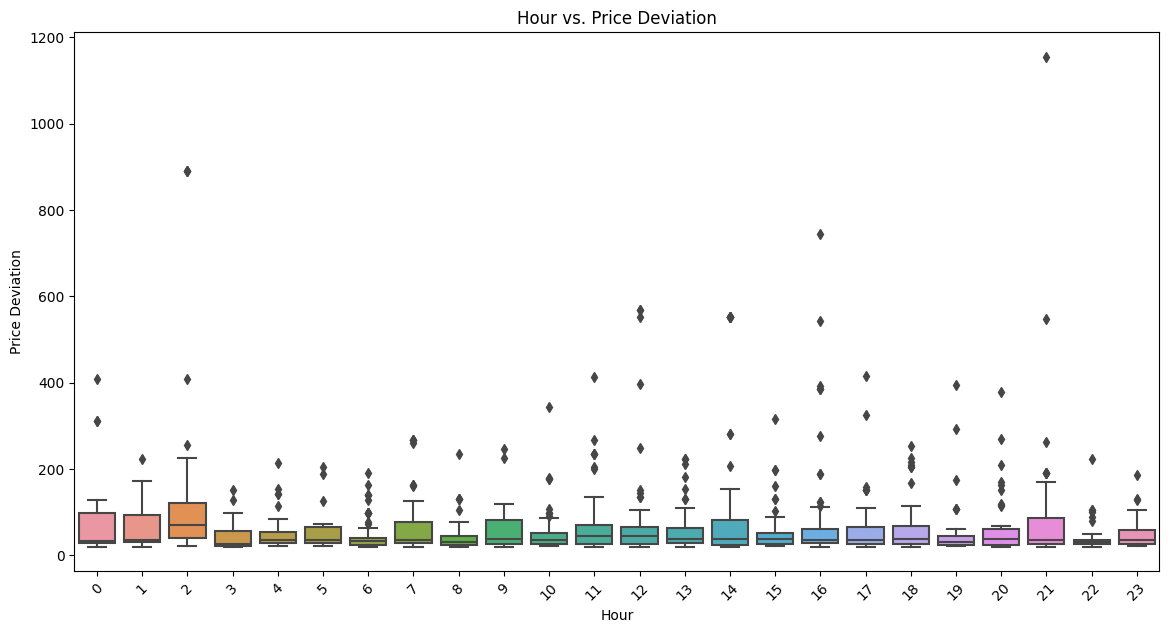

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot for hour vs. price_deviation
plt.figure(figsize=(14, 7))
sns.boxplot(x='hour', y='price_deviation', data=large_deviation_rides)
plt.title('Hour vs. Price Deviation')
plt.xlabel('Hour')
plt.ylabel('Price Deviation')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()


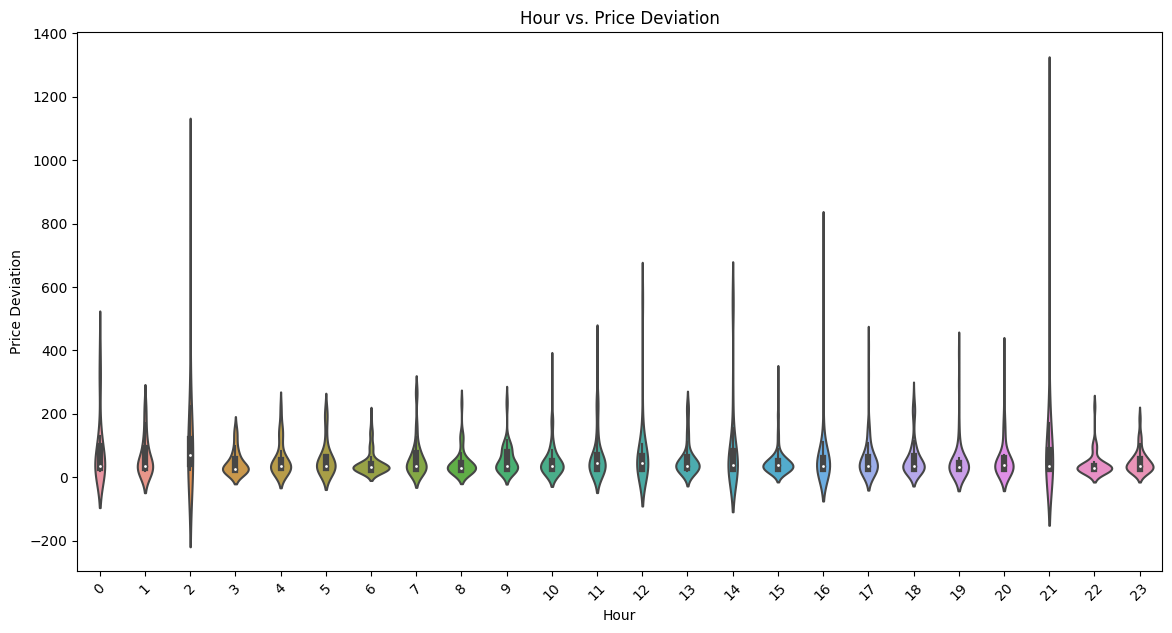

In [82]:
plt.figure(figsize=(14, 7))
sns.violinplot(x='hour', y='price_deviation', data=large_deviation_rides)
plt.title('Hour vs. Price Deviation')
plt.xlabel('Hour')
plt.ylabel('Price Deviation')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()


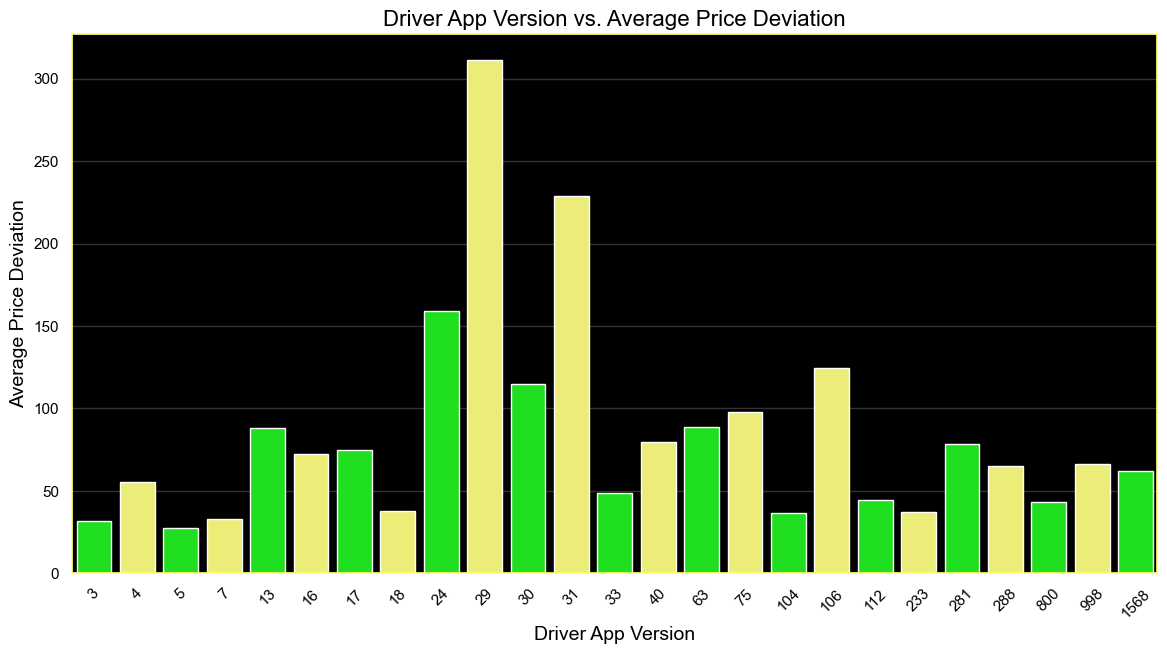

In [96]:
avg_price_deviation = large_deviation_rides.groupby('driver_app_version_freq')['price_deviation'].mean().reset_index()

# Set Blinkit-themed colors and style
plt.figure(figsize=(14, 7))
sns.set(style='whitegrid')
plt.rcParams['axes.facecolor'] = '#000000'  # Black background
plt.rcParams['axes.edgecolor'] = '#FFFF66'  # Yellow edges
plt.rcParams['grid.color'] = '#333333'  # Subtle dark gridlines
plt.rcParams['axes.labelcolor'] = '#000000'  # Yellow axis labels
plt.rcParams['xtick.color'] = '#000000'  # Yellow x-tick labels
plt.rcParams['ytick.color'] = '#000000'  # Yellow y-tick labels
plt.rcParams['text.color'] = '#000000'  # Yellow title and text

# Create the bar plot
sns.barplot(x='driver_app_version_freq', y='price_deviation', data=avg_price_deviation, palette=['#00FF00', '#FFFF66'])  # Green and Yellow bars
plt.title('Driver App Version vs. Average Price Deviation', fontsize=16, color='#000000')  # Yellow title
plt.xlabel('Driver App Version', fontsize=14, color='#000000')  # Yellow x-axis label
plt.ylabel('Average Price Deviation', fontsize=14, color='#000000')  # Yellow y-axis label
plt.xticks(rotation=45, color='#000000')  # Rotate x-axis labels, color yellow
plt.yticks(color='#000000')  # Yellow y-axis tick labels

plt.show()

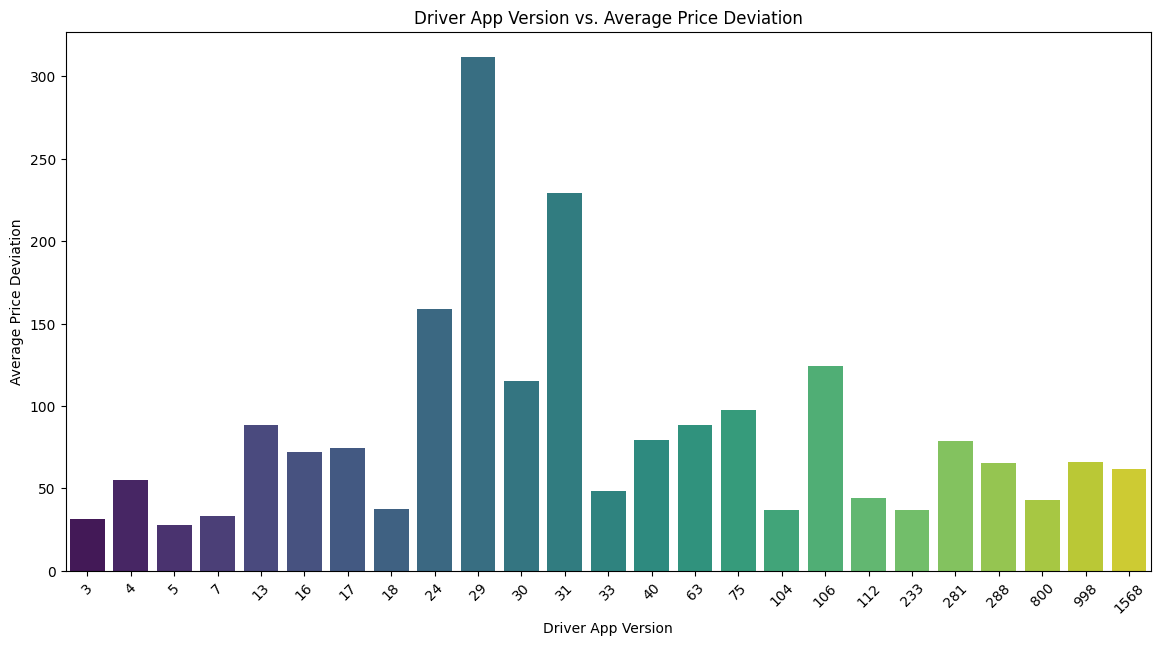

In [85]:
import pandas as pd

# Compute average price_deviation for each driver_app_version
avg_price_deviation = large_deviation_rides.groupby('driver_app_version_freq')['price_deviation'].mean().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(x='driver_app_version_freq', y='price_deviation', data=avg_price_deviation, palette='viridis')
plt.title('Driver App Version vs. Average Price Deviation')
plt.xlabel('Driver App Version')
plt.ylabel('Average Price Deviation')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()


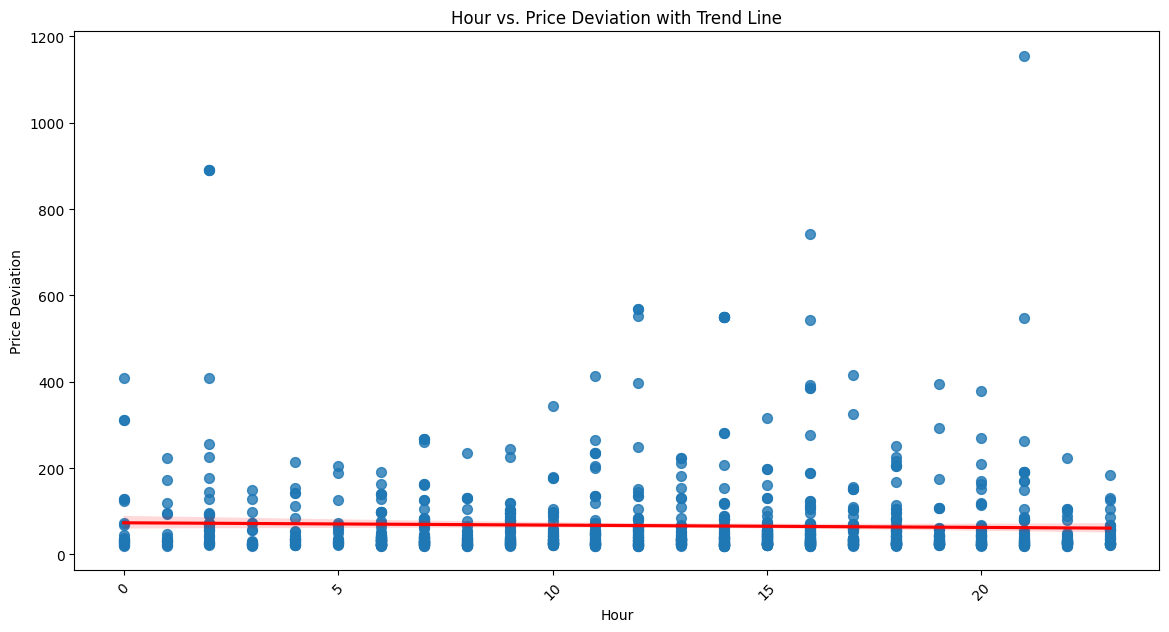

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for hour vs. price_deviation with trend line
plt.figure(figsize=(14, 7))
sns.regplot(x='hour', y='price_deviation', data=large_deviation_rides, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Hour vs. Price Deviation with Trend Line')
plt.xlabel('Hour')
plt.ylabel('Price Deviation')
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.show()
